## Scenario 1: Bank notes dataset

**Note:** This notebook accompanies the thesis with the title: xxx by Bibian Bennink. This notebook makes use of code created by others, and this work is explicitly linked. In the thesis document all sources will be properly cited too. 

###Introduction 
This notebook is used to compare Confidance Based Performance Estimation  [(CPBE)](https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html) created by NannyML and Continuous ReEvaluation [(CRE) ](https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button) created by Grzenda, Gomes and Bifet on the first scenario: Banknotes dataset. 

The banknotes data set is obtained from the UCI Machine Learning Repository where it is called: [banknote authentication Data Set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). The data in this dataset is extracted from images taken from genuine and gorged banknotes. 

In [43]:
#pip installs
!pip install nannyml
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nannyml 0.8.2 requires matplotlib<4.0.0,>=3.5.1, but you have matplotlib 3.1.3 which is incompatible.


In [44]:
# imports

# NannyML for CBPE
import nannyml as nml
from IPython.display import display

# General libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import datetime

# Classifier Library
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

###Loading in data and gathering information about the data.

In [45]:
#Connect drive files to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Reading in the banknote dataset and checking if it is read in correctly
data = pd.read_csv('/content/drive/MyDrive/Research project /data_banknote_authentication.txt', sep=",", header=None)
data.columns = ["variance", "skewness", "curtosis", "entropy","class"]
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [47]:
#Check the dataset values
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [48]:
#Check balance of the dataset
fraud = data['class'].value_counts()
print("Real %: ", fraud[1]/len(data)*100)
print("Fraud %:", fraud[0]/len(data)*100)

Real %:  44.460641399416915
Fraud %: 55.539358600583085


In [49]:
#splitting into X and y
X = data.loc[: ,data.columns != "class"]
y = data["class"]

#train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

In [50]:
# Get production data/ ground truth data ready and add ID column  
production_data = X_test.copy()
production_data['id'] = range(1, len(production_data) + 1)

ground_truth = X_test.copy()
ground_truth['class'] = y_test
ground_truth['id'] = range(1, len(ground_truth) + 1)

### Training the model

In [51]:
#training the Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("Train Score: ", rfc.score(X_train, y_train))

Train Score:  1.0


In [52]:
#training the Random Forest Classifier
rfc3 = RandomForestClassifier(max_depth = 3)
rfc3.fit(X_train, y_train)
print("Train Score: ", rfc3.score(X_train, y_train))

Train Score:  0.9635479951397327


In [53]:
#training the Random Forest Classifier
rfc1 = RandomForestClassifier(max_depth=1)
rfc1.fit(X_train, y_train)
print("Train Score: ", rfc1.score(X_train, y_train))

Train Score:  0.8590522478736331


### Functions needed for the algorithms to be tested.

In [54]:
# Calculate what the start and end time of the test will be based on the number
# of datapoints in the test dataset.
def running_time(n_datapoints):

  # one point every 10 minutes
  time_needed = (n_datapoints * 10)/60
  start_time = datetime.datetime.now() - datetime.timedelta(hours=time_needed)
  
  return start_time

In [55]:
# Get an array of 0 and 1, where 0 is sending a datapoint and 1 sending 
# the ground truth.

# send_gt: Every send_gt'th datapoint will be a ground truth 
# start_gt: The first ground truth will arrive from the start_gt'th datapoint
def get_send_distribution(send_gt,start_gt):
  
  distribution = [0]*start_gt
  datapoint_nr = start_gt

  for i in range(len(X_test)*2-start_gt):
    if i%send_gt == 0:
      distribution.append(1)
    elif datapoint_nr <= len(X_test)-1:
      distribution.append(0)
      datapoint_nr+=1
    else:
      distribution.append(1)

  return distribution

## CBPE

##### Functions

In [56]:
# Using the CBPE algorithm by NannyML according to their tutorial: 
#https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html
def use_CBPE(reference_df,analysis_df, k): 
  
  estimator = nml.CBPE(
      y_pred_proba='predict_proba',
      y_pred='y_hat',
      y_true='class',
      timestamp_column_name='timestamp',
      metrics=['roc_auc', 'f1', 'precision', 'recall', 'accuracy','specificity'],
      chunk_size=k,
      problem_type='classification_binary',
  )

  estimator.fit(reference_df)
  
  results = estimator.estimate(analysis_df)
  display(results.filter(period='analysis').to_df())
  
  #return both the estimator itself as the df of the results
  return estimator, results.filter(period='analysis').to_df()


##### Transforming the Data

In [90]:
# Paremeters
REF_ANA_SPLIT = 50
CHUNK = 50

In [91]:
# Copy of the data for safekeeping
CBPE_data = X_test.copy()
CBPE_data['class'] = y_test

# Two copies as from production_data rows will be dropped
CBPE_production_data = production_data.copy() 
CBPE_prod = CBPE_production_data.copy()

CBPE_ground_truth = ground_truth.copy()
CBPE_gt = CBPE_ground_truth.copy()

##### Testing *CBPE*

In [92]:
# Get the distribution that determines which datapoint gets send
CBPE_send_dist = get_send_distribution(send_gt = 20, start_gt = 50)

# defining the start and end time. 
start_time = running_time(len(X_test))
elapsed = 0

#Dataframes that will save the predictions and timestamps. 
reference_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp' ,'id'])
analysis_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp','id'])
ground_truth_time = pd.DataFrame(columns=['timestamp','id'])

for idx, i in enumerate(CBPE_send_dist):
  # Artificial time of the datapoint
  date_time = start_time + datetime.timedelta(minutes=elapsed)
  elapsed +=5
  # if 0, then a datapoint arrived
  
  if i == 0:
    # get datapoint
    x = CBPE_production_data.head(1)
    CBPE_production_data = CBPE_production_data.tail(-1)
    x_id = str(x['id'].iloc[0])
    datapoint = x.drop('id',axis=1)
    
    # get prediction
    y_hat = rfc1.predict(datapoint)
    probability = rfc1.predict_proba(datapoint)

    new_row= pd.DataFrame({'y_hat': y_hat,'predict_proba': probability[0][1], 'timestamp': date_time,'id': x_id})
    if idx < REF_ANA_SPLIT:
      reference_predictions = pd.concat([new_row, reference_predictions.loc[:]]).reset_index(drop=True)
    else: analysis_predictions = pd.concat([new_row, analysis_predictions.loc[:]]).reset_index(drop=True)
  
  # if 1, then the ground truth arrived
  if i == 1:
    # get ground truth
    y = CBPE_ground_truth.head(1)
    CBPE_ground_truth = CBPE_ground_truth.tail(-1)
    y_id = str(y['id'].iloc[0])

    new_row= pd.DataFrame.from_records([{'timestamp': date_time, 'id': y_id}])
    ground_truth_time = pd.concat([new_row, ground_truth_time.loc[:]]).reset_index(drop=True)


In [93]:
# Creating the reference dataset for the CBPE algorithm
reference_predictions['id']= reference_predictions['id'].astype(int)
reference_df = pd.merge(reference_predictions, CBPE_prod , on = 'id', how="inner")
f = CBPE_gt[['id','class']]
reference_df = pd.merge(reference_df, f , on = 'id', how="inner")
reference_df['y_hat'] = reference_df['y_hat'].astype(int)

# Creating the analysis dataset for the CBPE algorithm
analysis_predictions['id']= analysis_predictions['id'].astype(int)
analysis_df = pd.merge(analysis_predictions, CBPE_prod , on = 'id', how="inner")
analysis_df['y_hat'] = analysis_df['y_hat'].astype(int)

In [94]:
# Run the CBPE algorithm and check initial results
cbpe, CBPE_results = use_CBPE(reference_df, analysis_df, CHUNK)

chunk                                                               \
         key chunk_index start_index end_index                 start_date   
0     [0:49]           0           0        49 2023-01-23 09:12:29.232478   
1    [50:99]           1          50        99 2023-01-23 13:32:29.232478   
2  [100:149]           2         100       149 2023-01-23 17:57:29.232478   
3  [150:199]           3         150       199 2023-01-23 22:17:29.232478   
4  [200:249]           4         200       249 2023-01-24 02:42:29.232478   
5  [250:299]           5         250       299 2023-01-24 07:07:29.232478   
6  [300:349]           6         300       349 2023-01-24 11:27:29.232478   
7  [350:399]           7         350       399 2023-01-24 15:52:29.232478   
8  [400:498]           8         400       498 2023-01-24 20:17:29.232478   

                                              roc_auc                     ...  \
                    end_date    period sampling_error realized     value  ...   
0 2023-01-23 13:27:29.232478  analysis       0.033275      NaN  0.876683  ...   
1 2023-01-23 17:52:29.232478  analysis       0.033275      NaN  0.902578  ...   
2 2023-01-23 22:12:29.232478  analysis       0.033275      NaN  0.898287  ...   
3 2023-01-24 02:37:29.232478  analysis       0.033275      NaN  0.873042  ...   
4 2023-01-24 07:02:29.232478  analysis       0.033275      NaN  0.904739  ...   
5 2023-01-24 11:22:29.232478  analysis       0.033275      NaN  0.867028  ...   
6 2023-01-24 15:47:29.232478  analysis       0.033275      NaN  0.881384  ...   
7 2023-01-24 20:12:29.232478  analysis       0.033275      NaN  0.861810  ...   
8 2023-01-25 04:52:29.232478  analysis       0.023648      NaN  0.905525  ...   

         accuracy          specificity                     \
  lower_threshold alert sampling_error realized     value   
0             0.8  True       0.071165      NaN  0.707726   
1             0.8  True       0.071165      NaN  0.782355   
2             0.8  True       0.071165      NaN  0.821157   
3             0.8  True       0.071165      NaN  0.680833   
4             0.8  True       0.071165      NaN  0.806450   
5             0.8  True       0.071165      NaN  0.655777   
6             0.8  True       0.071165      NaN  0.868098   
7             0.8  True       0.071165      NaN  0.753624   
8             0.8  True       0.050575      NaN  0.779740   

                                                                       \
  upper_confidence_boundary lower_confidence_boundary upper_threshold   
0                  0.921220                  0.494232        0.823529   
1                  0.995849                  0.568860        0.823529   
2                  1.000000                  0.607662        0.823529   
3                  0.894327                  0.467339        0.823529   
4                  1.000000                  0.592955        0.823529   
5                  0.869272                  0.442283        0.823529   
6                  1.000000                  0.654604        0.823529   
7                  0.967118                  0.540130        0.823529   
8                  0.931464                  0.628016        0.823529   

                         
  lower_threshold alert  
0        0.823529  True  
1        0.823529  True  
2        0.823529  True  
3        0.823529  True  
4        0.823529  True  
5        0.823529  True  
6        0.823529  True  
7        0.823529  True  
8        0.823529  True  

[9 rows x 55 columns]

##### Evaluation of CBPE

In [95]:
#CBPE metrics
CBPE_accuracy= CBPE_results['accuracy']['value']
CBPE_f1= CBPE_results['f1']['value']
CBPE_precision= CBPE_results['precision']['value']
CBPE_roc_auc= CBPE_results['roc_auc']['value']
CBPE_recall= CBPE_results['recall']['value']
CBPE_specificity= CBPE_results['specificity']['value']

print(CBPE_accuracy, CBPE_f1,CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity)

0    0.792006
1    0.820113
2    0.823055
3    0.750597
4    0.820538
5    0.771063
6    0.841396
7    0.791914
8    0.816802
Name: value, dtype: float64 0    0.777169
1    0.765432
2    0.743640
3    0.717360
4    0.748601
5    0.782159
6    0.719088
7    0.759462
8    0.746471
Name: value, dtype: float64 0    0.671687
1    0.667045
2    0.675361
3    0.608654
4    0.667991
5    0.685000
6    0.676667
7    0.684375
8    0.635714
Name: value, dtype: float64 0    0.876683
1    0.902578
2    0.898287
3    0.873042
4    0.904739
5    0.867028
6    0.881384
7    0.861810
8    0.905525
Name: value, dtype: float64 0    0.921953
1    0.897864
2    0.827276
3    0.873338
4    0.851338
5    0.911436
6    0.767184
7    0.853056
8    0.903962
Name: value, dtype: float64 0    0.707726
1    0.782355
2    0.821157
3    0.680833
4    0.806450
5    0.655777
6    0.868098
7    0.753624
8    0.779740
Name: value, dtype: float64


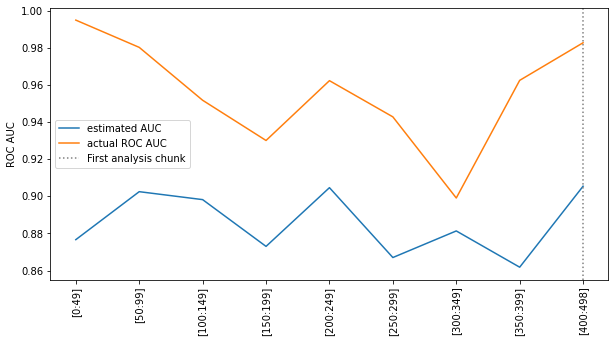

In [96]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_targets = CBPE_gt[['id','class']]
analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
#df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'predict_proba'
actual_performance = []
for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    CBPE_results.loc[idx, ('roc_auc', 'realized')] = actual_perf
# plot
first_analysis = CBPE_results[('chunk', 'key')].values[8]
plt.figure(figsize=(10,5))
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('roc_auc', 'value')], label='estimated AUC')
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('roc_auc', 'realized')], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

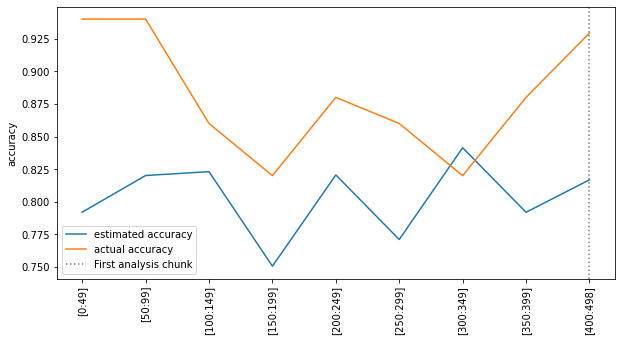

In [97]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_targets = CBPE_gt[['id','class']]
analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
#df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'predict_proba'
actual_performance = []
for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = accuracy_score(sub[target_col], round(sub[pred_score_col]))
    CBPE_results.loc[idx, ('accuracy', 'realized')] = actual_perf
# plot
first_analysis = CBPE_results[('chunk', 'key')].values[8]
plt.figure(figsize=(10,5))
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'value')], label='estimated accuracy')
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'realized')], label='actual accuracy')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('accuracy')
plt.legend()
plt.show()

###CRE

##### Functions

In [80]:
# Place the predicted datapoints in the right bins
def card (P, B):
  datapoint_series = P.copy()
  initial_y_hat, starttime, b1 = datapoint_series[0]
  final_y_hat, endtime, bfinal = datapoint_series[-1]
  
  # time passed since datapoint first arrived
  time_passed = endtime-starttime
  timebloks = time_passed/B
  
  # make timebloks
  timeblok_array = []
  for i in range(B):
    timeblok_array.append(starttime + (i+1)*timebloks)

  # If the point does not have an bin, place it in the correct bin.
  for indx, instance in enumerate(datapoint_series):
    y_hat, time, B = instance
    if B == -1:
      for idx, i in enumerate(timeblok_array):
        if time <= i:
          datapoint_series[indx] = (y_hat, time, idx)
    else:
      continue
  return datapoint_series


##### Testing CRE

In [98]:
# testing CRE
CRE_send_dist = get_send_distribution(send_gt = 20, start_gt = 50)

# copy arrays and add a id column
CRE_production_data = production_data.copy()
CRE_ground_truth = ground_truth.copy()
CRE_ground_truth_calc = ground_truth.copy()

#lists to store initial predictions and final predictions
CRE_predictions = pd.DataFrame(columns=['y_hat','id'])
CRE_final_predictions = pd.DataFrame(columns=['y_hat','id'])
B = 5
K= 10

#copy of the data
new_data=X_train.copy()
new_data['class']=y_train

#Dictionary of waiting instances per index:
#[x_k,?] = instance without ground truth
#l = (number of labeled instances)
L = {}

#Dictionary of lists of prediction tuples
P = {}

#define model
model = rfc1

#define start and endtime
start_time = running_time(len(X_test))
elapsed = 0


In [99]:
# CRE based if pseudocode from the paper by Grzenda, Gomes and Bifet
# https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button
for time, i in enumerate(CRE_send_dist):
  #Model used for prediction
  date_time = start_time + datetime.timedelta(minutes=elapsed)
  elapsed +=5

  # if i == 0 it is a datapoint
  if i == 0:
    # get the datapoint and drop it from the list
    x = CRE_production_data.head(1)
    CRE_production_data = CRE_production_data.tail(-1)
    x_id = str(x['id'].iloc[0])
    
    #get data for prediction
    prod_data = x.drop('id',axis=1)
    
    #predict point and add to prediction dataframe
    y_hat = model.predict(prod_data)
    new_row= pd.DataFrame({'y_hat': y_hat, 'id': x_id})
    CRE_predictions = pd.concat([new_row,CRE_predictions.loc[:]]).reset_index(drop=True)

    L[x_id]= [(x,0)]
    P[x_id] = [(y_hat[0], date_time, 0)]

  # if i ==1 it is the ground truth
  else:
    # get the datapoint and drop it from the list
    y = CRE_ground_truth.head(1)
    CRE_ground_truth = CRE_ground_truth.tail(-1)
    y_id = str(y['id'].iloc[0])

    #Add final prediction to P
    GT_data = y.drop(['id','class'],axis=1)
    
    #predict point and add to prediction dataframe
    y_hat = model.predict(GT_data)
    new_row= pd.DataFrame({'y_hat': y_hat, 'id': y_id})
    CRE_final_predictions = pd.concat([new_row,CRE_final_predictions.loc[:]]).reset_index(drop=True)
    P[y_id].append((y['class'].iloc[0], date_time, B+1))

    #CALCULATE_PERFORMANCE(P[x['index']], time)
    P[y_id] = card(P[y_id],B)

    new_row= {'variance': y["variance"], 'skewness': y["skewness"], 'curtosis': y["curtosis"], 'entropy': y["entropy"], 'class':y["class"]}
    new_data.append(new_row, ignore_index = True)
    
    # Remove from waiting dict
    popped = L.pop(y_id)
    for key in L:
      if (L[key][-1][1]%K) ==0:
        y_hat = model.predict(L[key][0][0].drop('id',axis=1))
        P[key].append((y_hat, date_time, -1))
      lst =list(L[key][-1])
      lst[1]=L[key][-1][1]+1
      L[key][-1]= tuple(lst)
    
    #train the model with the new datapoint added
    new_rfc1 = RandomForestClassifier(max_depth = 1)
    model = new_rfc1.fit(new_data.drop('class',axis=1), new_data['class'])

##### Evaluation of CRE

In [100]:
# Function to get the scores
def get_scores(actual, predictions):
  accuracy= accuracy_score(actual, predictions)
  f1= f1_score(actual, predictions)
  precision= precision_score(actual, predictions)
  roc_auc= roc_auc_score(actual, predictions)
  recall= recall_score(actual, predictions)
  # specificty is recall of negative class
  specificity= recall_score(actual, predictions, pos_label=0)
  return accuracy, f1, precision, roc_auc, recall, specificity


In [101]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
# calculate metrics:

# Sort the predictions by id such that it matches the ground truth dataframe
CRE_predictions.id = CRE_predictions.id.astype(float)
sorted_CRE_predictions = CRE_predictions.sort_values(by=['id'])

CRE_final_predictions.id = CRE_final_predictions.id.astype(float)
sorted_CRE_final_predictions = CRE_final_predictions.sort_values(by=['id'])

# Get the array of ground truths and predictions. 
gr = CRE_ground_truth_calc['class'].to_numpy()
CRE_pred = sorted_CRE_predictions['y_hat'].to_numpy().astype(int)
CRE_final_pred = sorted_CRE_final_predictions['y_hat'].to_numpy().astype(int)


CRE_accuracy, CRE_f1, CRE_precision, CRE_roc_auc, CRE_recall, CRE_specificity = get_scores(gr, CRE_pred)

CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_roc_auc, CRE_final_recall, CRE_final_specificity= get_scores(gr, CRE_final_pred)

In [102]:
print(CRE_accuracy, CRE_f1, CRE_precision, CRE_roc_auc, CRE_recall, CRE_specificity)
print(CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_roc_auc, CRE_final_recall, CRE_final_specificity)

0.9034608378870674 0.8869936034115138 0.9203539823008849 0.8985717743887679 0.8559670781893004 0.9411764705882353
0.8816029143897997 0.8614072494669509 0.8938053097345132 0.8764221738077949 0.831275720164609 0.9215686274509803
